# 2019-nCoV outbreak analysis

## Background
A novel coronavirus (2019-nCoV) outbreak has been continuing in China, while a few imported cases are observed in the neighbouring countries. Although the spread across China suggests a certain amount of human-to-human transmisison, there has not been any observed in those countries which saw travel cases. This suggests that not all symptomatic cases lead to a secondary transmission, which was also the case in the past SARS/MERS outbreaks. Furthermore, even if any subclinical cases had been imported into these countries undetected, at least such cases did not contributed to secondary transmissions from which a detectable case originates.


## Model
Let $J_t$ and $I_t$ be the incidence of imported and local cases of nCoV detected in a country outside China.
Let $q_t$ be the (potentially time-dependent) detection probability of nCoV infection, which is understood as the combination of both symptomatic ratio and proper reporting, and $s_\tau$ be the distribution of the serial interval (i.e. time between the linked infection pairs) of nCoV.

Assuming that the risk of importing an nCoV case follows an exponential hazard function, reflecting an ongoing outbreak in China as of February 2020, the overall (including those undetected) number of imported cases $j_t$ is given as 
$$
j_t\sim \mathrm{Pois}(\lambda_t), \\
h_t=h_0\exp(r t)
$$

We model the offspring distribution of nCoV by a negative binomial distribution $\mathrm{NB}\left(k,\frac{k}{R_0+k}\right)$, where $R$ is the mean (i.e. the basic reproduction number) and $k$ is the overdispersion parameter. The reproductive property of the negative binomial distriubution assures that the number of secondary infections caused by the overall infector at time $t$ follows $\mathrm{NB}\left(k(i_t+j_t),\frac{k}{R_0+k}\right)$, and we assume these offsprings are distributed on the timeline $t$ according to the serial interval distribution $s_\tau$.

Since sampling from a negative binomial distribution is identical to sequentially sampling from Gamma and Poisson distributions, we can construct the renewal process as
$$
i_t \sim \mathrm{Pois}\left(\sum_{\tau=1}^\infty \lambda_{t-\tau},s_\tau \right),\\
\lambda_t\sim\mathrm{Gamma}\left(k(i_{t-\tau}+j_{t-\tau}),\frac{R_0}{k}\right).
$$
Here, $\lambda_t$ is the total force of infection caused by $i_t$: infectious individuals with onset $t$.

The observation of cases is assumed to follow the binomial sampling:
$$
I_t\sim \mathrm{Binom}(i_t,q_t), \\
J_t\sim \mathrm{Binom}(j_t,q_t)
$$

We assumed the probability of detection $q_t$ might have been lower before the epidemic became widely recognised. Because of reporting delays, the most recent data might have also been underreported. We model $q_t$ as
$$
q_t=Q(t)\delta(t), \\
\delta(t)=1-\exp\left(\frac{1}{d}(T-t)\right),
$$
where $Q(t)$ is the baseline reporting probability at time $t$ and $\delta(t)$ is the factor reflecting the delay. We assume the distribution of reporting delays follow an exponential distribution with mean $d$.

## Statistical analysis
We assumed the observed imported/local cases $I_t,J_t$ and the serial interval distribution $S_t$ are given. Of the unkown variables, $i_t$, $j_t$ and $\lambda_t$ are integrated out by the particle-Metropolis-Hastings algorithm and the remaining variables $R_0, k, h_0,r,q,d$ are inferred.


## Data
Reported cases outsie China by onset dates were extracted from the WHO situation reports (Situation Report 14 as of 4/2/2020, accessed on the same day). We considered cases with a travel history in china as imported cases, and cases labelled as "locally acquired" as local cases. We did not included those labelled as "Under investigation" in this analysis.

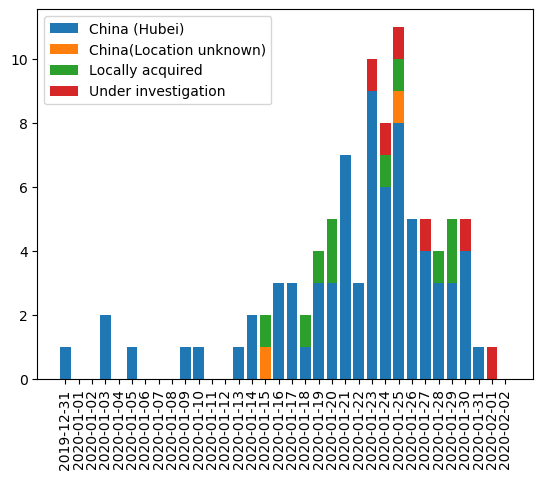

In [300]:
# Show incidence data
using DataFrames, Dates, PyPlot
# Imported and local cases outside China
# Source (accessed 4/2/2020): https://www.who.int/docs/default-source/coronaviruse/situation-reports/20200204-sitrep-15-ncov.pdf
dates=Date("2019-12-31"):Day(1):Date("2020-2-2")
china_hubei  =[1,0,0,2,0,1,0,0,0,1,1,0,0,1,2,0,3,3,1,3,3,7,3,9,6,8,5,4,3,3,4,1,0,0]
china_unknown=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
localcases   =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,2,0,0,0,1,1,0,0,1,2,0,0,0,0]
u_inv        =[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,0,1,0]
casedata=DataFrame([dates,china_hubei,china_unknown,localcases,u_inv], [:date,:china_hubei,:china_unknown,:loc,:underinv])
barplots=PyPlot.bar.(Ref(1:length(casedata.date)),[Vector(casedata[:,c]) for c in 2:5],0.8,[cumsum(hcat(zeros(Int,length(casedata.date)),Matrix(casedata[:,2:5])),dims=2)[:,c] for c in 1:4])
PyPlot.xticks(1:length(casedata.date),dates,rotation="vertical")
PyPlot.legend(getindex.(barplots,1),["China (Hubei)","China(Location unknown)","Locally acquired","Under investigation"]);

In [301]:
# Data preparation
const initdate=Date("2019-9-13")
const newyeardate=Date("2020-1-1")
# Possible (earliest bound of) the estimted start of the outbreak
# Source: http://virological.org/t/preliminary-phylogenetic-analysis-of-11-ncov2019-genomes-2020-01-19/329
const timelines=initdate:Day(1):Date("2020-2-3")
const tlen=length(timelines)
imported=zeros(Int,tlen)
loc=zeros(Int,tlen)
datesid=findall(x->x in dates,timelines)
imported[datesid].=casedata.china_hubei.+casedata.china_unknown
loc[datesid].=casedata.loc
observed=(imported=imported,loc=loc);

## Setups

In [302]:
# Packages
using Mamba, Distributions, LinearAlgebra
# Distributions
NBmu(mu,k)=NegativeBinomial(k,mu/(mu+k))
Gmusd(mu,sd)=Gamma(mu^2/sd^2, sd^2/mu)
module DSI
using Distributions
struct DiscreteSerialInterval{T<:NamedTuple,F<:AbstractFloat, D<:Distribution}
    params::T; dist::D; distvec::Vector{F}
end
end
function DSIconstruct(distconstructor,params,tlen)
    dist=distconstructor(params...)
    distvec=cdf.(dist,0:tlen) |> diff
    DSI.DiscreteSerialInterval(params,dist,distvec)
end
SIparams=(μ=7.0,σ=3.0)
SIdist=Gmusd(SIparams...)
serialint=DSIconstruct(Gamma,NamedTuple{(:α,:θ)}(params(SIdist)),tlen)

# utils
function sysresample(weights)
    size=length(weights)
    weights=weights/sum(weights) # normalise
    cumweights=cumsum(weights)
    randomiser=floor.(Int,cumweights.*size.+rand())
    freqs=randomiser.-[0; randomiser[1:end-1]]
    return(reduce(vcat,fill.(1:size,freqs)))
end

sysresample (generic function with 1 method)

## Simulation functions

In [303]:
using Distributions, StatsFuns, StatsBase, SpecialFunctions, Parameters
function smc!(infness_pts::NamedTuple{(:imported,:loc),T} where T,cases_pts::NamedTuple{(:imported,:loc),T} where T,hazard_pts::NamedTuple{(:imported,:loc),T} where T,nbparm,detectprob,gtimevec,observed)
    nsample=size(infness_pts.imported,2)
    tlen=length(observed.loc)
    lweights=zeros(nsample)
    llkh=0.0
    α,p=nbparm
    θ=(1-p)/p
    for t in 1:length(observed.loc)
        for tag in keys(cases_pts)
            # draw cases
            @views cases_pts[tag][t,:].=observed[tag][t].+rand.(Poisson.((1-detectprob[t]).*hazard_pts[tag][t,:]))
            #draw gamma: total offsprings
            nonzerocase=cases_pts[tag][t,:].!=0 # to avoid Gamma(0,θ)
            if sum(nonzerocase)!=0 @views infness_pts[tag][t,nonzerocase].=rand.(Gamma.(α.*cases_pts[tag][t,nonzerocase],θ)) end
            #distribute infness on timeline
            hazard_pts.loc[t+1:end,:] .+= (@view infness_pts[tag][t:t,:]).*gtimevec[1:tlen-t]
            @views lweights.+=logpdf.(Poisson.(detectprob[t].*hazard_pts[tag][t,:]),observed[tag][t])
        end
        if all(lweights.≤-Inf) llkh=-Inf;break end
        if 2logsumexp(lweights)-logsumexp(2 .*lweights)< log(nsample)-log(2) || t==tlen
            # resample
            llkh+=logsumexp(lweights)-log(nsample)
            lweights.-=maximum(lweights)
            newid=sysresample(exp.(lweights))
            for tag in keys(cases_pts)
                @views infness_pts[tag][1:t,:].=infness_pts[tag][1:t,newid]
                @views cases_pts[tag][1:t,:].=cases_pts[tag][1:t,newid]
            end
            @views hazard_pts.loc[1:t,:].=hazard_pts.loc[1:t,newid]
            lweights.=0.0
        end
    end
    return(llkh)
end
function llkhpf!(paths,nsample,branchdist,gtimedist,observed,detectprob,tlen)
    particles=(infness_pts=(imported=zeros(tlen,nsample), loc=zeros(tlen,nsample)),
    hazard_pts=(imported=paths.hazard.imported,loc=zeros(tlen,nsample)),
    cases_pts=(imported=zeros(Int,tlen,nsample),loc=zeros(Int,tlen,nsample)))
    @unpack infness_pts,cases_pts,hazard_pts = particles
    @unpack infness,cases,hazard=paths
    gtimevec=diff(cdf.(gtimedist,0:tlen))
    counts=0
    ll=0.0
    while true
        infness_pts.imported.=0.0
        infness_pts.loc.=0.0
        hazard_pts.loc.=0.0
        ll=smc!(infness_pts,cases_pts,hazard_pts,params(branchdist),detectprob,gtimevec,observed)
        counts+=1
        if ll>-Inf break end
        if counts>100 print("infness could not be sampled in 100 SMC iterations") end
    end
    # sample one particle
    sampleid=sample(1:nsample)
    @views infness.imported.=infness_pts.imported[:,sampleid]
    @views infness.loc.=infness_pts.loc[:,sampleid]
    @views cases.imported.=cases_pts.imported[:,sampleid]
    @views cases.loc.=cases_pts.loc[:,sampleid]
    @views hazard.loc.=hazard_pts.loc[:,sampleid]
    ll
end
function importhazard(param)
    @unpack h0,r=param
    @. h0*exp(r*((1:tlen)-Dates.value(newyeardate-initdate)-1))
end
function detectprob(param)
    @unpack q,delayrate=param
    @. q*(1.0-exp(-delayrate*(tlen-(1:tlen))))
end

detectprob (generic function with 1 method)

In [304]:
# test simulation run
nb=NBmu(2,0.5)
gt=Gmusd(7,1)
R0=2
k=0.5
h0=10
r=0.05
qt=fill(0.1,tlen)
nsample=1000

paths=(hazard=(imported=importhazard((h0=h0,r=r)),loc=zeros(tlen)),
        cases=(imported=zeros(Int,tlen),loc=zeros(Int,tlen)),
        infness=(imported=observed.imported.+0.0,loc=observed.loc.+0.0))

@time lls=llkhpf!(paths,nsample,nb,gt,observed,qt,tlen)
#@time lls=infnessgibbs!(infness,hazard.loc,500,nb,gt,tlen,cases);
#@time casescondsampler!(cases,infness,hazard,params(nb),observed,q);
#@time llnbdist(params(nb),infness,cases)
#@time lldetectprob(qt,cases,observed)
#@time llimporthazard((h0,r),cases)
#using RCall;@rimport base as R

  1.212222 seconds (3.68 M allocations: 334.805 MiB, 9.85% gc time)


-116.96640460482955

## MCMC sampling

In [305]:
# unknown variables: λ, i, j, R₀, k, q
parms=Dict{Symbol,Any}(
    :h₀=>0.1,
    :r=>0.1,
    :R₀=>1.0,
    :k=>0.5,
    :nlogq=>0.5,
    :delayrate=>0.1
)
priors=Dict{Symbol,Any}()
for parname in keys(parms)
    priors[parname]=Stochastic(()->Uniform(0,5))
end
#priors[:nlogq]=Stochastic(1,()->Uniform(0,5))
dotter=[100]
inputs=Dict{Symbol,Any}(
    :observed=>observed,
    :paths=>paths,
    :zerotrick=>0.0,
    :invtemp=>1.0,
    :smcsize=>100,
    :counter=>([0],dotter)
)

inits=merge(parms,inputs)
#inits=copy(parms)
inits=[inits]

model=Model(
    j=Logical(1,(paths,k)-> paths.cases.imported),
    i=Logical(1,(paths,k)-> paths.cases.loc),
    ll_smc=Logical((R₀,k,h₀,r,nlogq,delayrate,observed,paths,smcsize)->begin
        paths.hazard.imported.=importhazard((h0=h₀,r=r))
        nb=NBmu(R₀,k)
        qt=detectprob((q=exp(-nlogq),delayrate=delayrate))
        ll=llkhpf!(paths,smcsize,nb,serialint.dist,observed,qt,tlen)
        ll
    end),
    lltotal=Logical((ll_smc,invtemp)->ll_smc*invtemp
        , false),
    zerotrick=Stochastic((lltotal,i,j)->Poisson(-lltotal),false),
    count=Logical((counter,k)->0);
    priors...
)
countup=Sampler([:count],
    (count,counter)->begin
        counter[1].+=1
        if counter[1][1]==counter[2][1]
            counter[1].=0
            print(".")
        end
        count+=1
    end
)
    
setsamplers!(model,[AMM(collect(keys(parms)),Matrix{Float64}(I,fill(length(keys(parms)),2)...).*0.05),countup]);

In [313]:
mcmclen=100000
burn=div(mcmclen,5)
dotter.=div(mcmclen,100)

chain = mcmc(model, inputs, inits, mcmclen, burnin=burn, thin=div(mcmclen,500), chains=1, verbose=true)

MCMC Simulation of 100000 Iterations x 1 Chain...

Chain 1:   0% [0:58:50 of 0:58:50 remaining]
..........Chain 1:  10% [0:55:09 of 1:01:17 remaining]
..........Chain 1:  20% [1:47:59 of 2:14:59 remaining]
..........Chain 1:  30% [1:16:17 of 1:48:59 remaining]
..........Chain 1:  40% [0:59:50 of 1:39:44 remaining]
..........Chain 1:  50% [0:47:50 of 1:35:40 remaining]
..........Chain 1:  60% [0:37:41 of 1:34:12 remaining]
..........Chain 1:  70% [0:37:09 of 2:03:51 remaining]
..........Chain 1:  80% [0:24:52 of 2:04:21 remaining]
..........Chain 1:  90% [0:11:52 of 1:58:44 remaining]
..........Chain 1: 100% [0:00:00 of 2:02:53 remaining]



Object of type "ModelChains"

Iterations = 20200:100000
Thinning interval = 200
Chains = 1
Samples per chain = 400

[0.1700717041171804 2.915715479334395 … 0.42586302443562585 -80.68582294760616; 0.1745060894768227 0.9302325325675693 … 1.9954296229991566 -79.30633722645707; … ; 0.124379696431757 1.3967713153225392 … 2.405388705898175 -80.91977958805272; 0.16311103153986403 2.484764491310082 … 1.4489495349235604 -79.41975135905167]

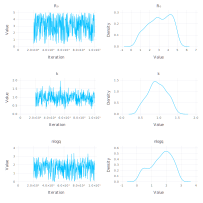

Press ENTER to draw next plot


stdin>  


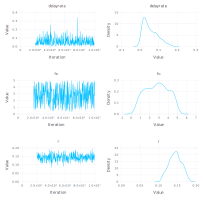

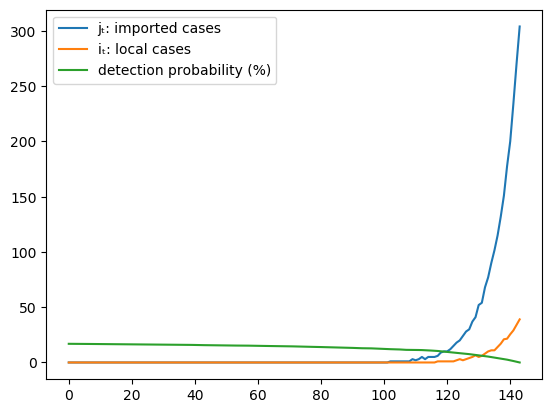

Mamba.draw(Mamba.plot(chain[:, showparam, :])) = nothing


In [314]:
showparam=[:R₀,:k,:nlogq,:delayrate,:h₀,:r]
@show Mamba.draw(Mamba.plot(chain[:,showparam,:]))
# Visualise
i=chain[:,:i,:].value
im=median(i,dims=1)[1,:,1]
j=chain[:,:j,:].value
jm=median(j,dims=1)[1,:,1]
q=median(hcat([detectprob((q=exp(-chain[t,:nlogq,1].value[1]),delayrate=chain[t,:delayrate,1].value[1])) for t in chain.range]...),dims=2)
inferredvars=PyPlot.plot.([jm,im,q.*100])
PyPlot.legend(getindex.(inferredvars,1),["jₜ: imported cases","iₜ: local cases","detection probability (%)"]);

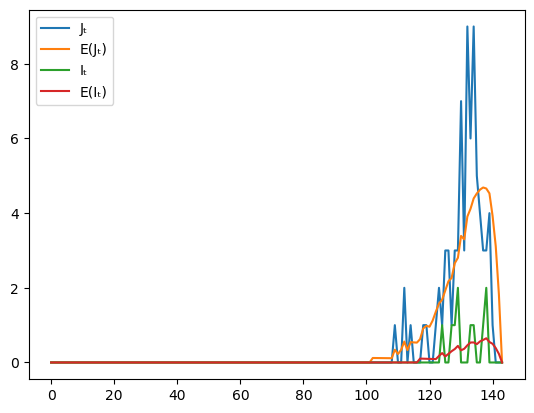

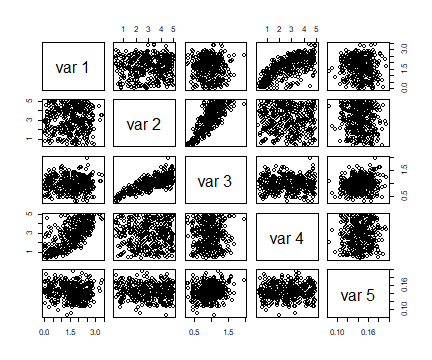

fittodata = PyPlot.plot.([observed.imported, jm .* q[:, 1], observed.loc, im .* q[:, 1]]) = Array{PyCall.PyObject,1}[[PyObject <matplotlib.lines.Line2D object at 0x0000000041D76320>], [PyObject <matplotlib.lines.Line2D object at 0x0000000041D761D0>], [PyObject <matplotlib.lines.Line2D object at 0x0000000041D76FD0>], [PyObject <matplotlib.lines.Line2D object at 0x0000000041D76B38>]]


RObject{NilSxp}
NULL


In [315]:
@show fittodata=PyPlot.plot.([observed.imported,jm.*q[:,1],observed.loc,im.*q[:,1]])
PyPlot.legend(getindex.(fittodata,1),["Jₜ","E(Jₜ)","Iₜ","E(Iₜ)"]);
using RCall;@rimport graphics as rg;
rg.pairs(chain[:,[:nlogq,:R₀,:k,:h₀,:r],:].value[:,:,1])

In [317]:
# Save chain
using Serialization
serialize(open("pmcmc_chain100000", "w"), chain)